In [1]:
%load_ext autoreload
%autoreload 2
import gc
import sys
from datetime import datetime

gc.collect()

paths_to_add = ['/home/jovyan/work', '/home/jupyter/alpha_media_signal']

for p in paths_to_add:
    if p not in sys.path:
        sys.path.append(p)

import pandas as pd

%matplotlib inline

from pathlib import Path

from ams.config import constants, logger_factory
from ams.services import twitter_service
from ams.services import ticker_service

from ams.notebooks.twitter.twitter_ml_utils import WorkflowMode, get_data_for_predictions
from ams.notebooks.twitter import twitter_ml_utils
from ams.utils import date_utils

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

logger = logger_factory.create(__name__)

In [2]:
overall_roi = None

df_rec_quart_drop = None
def get_quarterly_data():
    global df_rec_quart_drop
    if df_rec_quart_drop is None:
        df_rec_quart_drop = twitter_service.get_all_quarterly_data_for_twitter()
    return df_rec_quart_drop.copy()

overall_roi = []
# today_dt_str = date_utils.get_standard_ymd_format(datetime.now())
learning_prep_dir = Path(constants.TWITTER_GREAT_REDUCTION_DIR, "main")
df_tweets = twitter_ml_utils.load_twitter_raw(learning_prep_dir=learning_prep_dir)
# df_tweets = df_tweets.sample(frac=.25)

start_date = "2020-08-16"
days_after_start = 3
predict_date_str = twitter_ml_utils.get_next_market_date(start_date, days_after_start)
num_hold_days = 1

cat_uniques = None
model_xgb = None
workflow_mode = WorkflowMode.Training

dt = date_utils.parse_std_datestring(predict_date_str)
if date_utils.is_stock_market_closed(dt):
    logger.info("No can do. Market closed.")

logger.info(f"Filtering twitter data to on or before '{predict_date_str}'.")
df_tweets = df_tweets[df_tweets["date"] <= predict_date_str]

2021-01-16 23:13:00,140 - __main__ - INFO - Filtering twitter data to on or before '2020-08-19'.


2021-01-16 23:13:00,341 - __main__ - INFO - Max date: 2020-08-19
2021-01-16 23:13:00,342 - __main__ - INFO - Num tweet records: 17,034


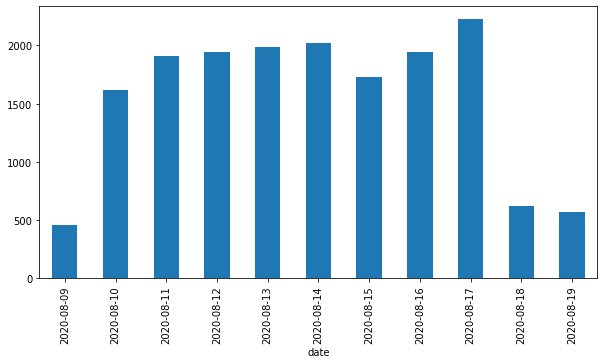

In [3]:
if df_tweets.shape[0] == 0:
    logger.info(f"No twitter data on {predict_date_str}")

logger.info(f"Max date: {df_tweets['date'].max()}")
logger.info(f"Num tweet records: {df_tweets.shape[0]:,}")

twitter_ml_utils.show_distribution(df=df_tweets)

In [4]:
logger.info("Converting twitter data - phase I ...")
df_booled = twitter_service.convert_to_bool(df=df_tweets)
df_twitter = twitter_ml_utils.convert_twitter_to_numeric(df=df_booled)

logger.info("Getting Twitter stock data ...")
df_stock_tweets = df_tweets[df_tweets["date"] < predict_date_str]
logger.info(f"Num df_stock_tweets: {df_stock_tweets.shape[0]}")
df_stock_data = twitter_ml_utils.get_twitter_stock_data_2(df_tweets=df_stock_tweets,
                                                        num_hold_days=num_hold_days)

logger.info(f"Num Twitter stock data records: {df_stock_data.shape[0]}")
df_tmp = df_stock_data.sort_values(by=["date"], ascending=False)

2021-01-16 23:13:00,612 - __main__ - INFO - Converting twitter data - phase I ...
2021-01-16 23:13:00,844 - __main__ - INFO - Getting Twitter stock data ...
2021-01-16 23:13:00,849 - __main__ - INFO - Num df_stock_tweets: 16467
2021-01-16 23:13:28,051 - __main__ - INFO - Num Twitter stock data records: 9792


In [5]:
# Select all the rows df_twitter records on predicted_date_str, get a unique list of tickers
print(df_stock_data["date"].max())
prediction_tickers = list(df_twitter[df_twitter["date"] == predict_date_str]["f22_ticker"].unique())
print(f"Num pred tickers: {len(prediction_tickers)}")

future_date = twitter_ml_utils.get_next_market_date(predict_date_str, num_hold_days)

rows = []
attributes = ("volume", "close")
for t in prediction_tickers:
    prev_volume, prev_close = ticker_service.get_most_recent_stock_values(ticker=t, attributes=attributes)
    rows.append({"ticker": t, "date": predict_date_str, "future_date": future_date,
                 "prev_volume": prev_volume, "prev_close": prev_close
                })
    
df_stock_predict_data = pd.DataFrame(rows)
df_sd_futured = pd.concat([df_stock_data, df_stock_predict_data], axis=0)
logger.info(f"Num futured: {df_sd_futured.shape[0]}")

2020-08-18
Num pred tickers: 567
2021-01-16 23:13:30,706 - __main__ - INFO - Num futured: 10359


In [6]:
logger.info("Getting Twitter stock quarterly data ...")
df_rec_quart_drop = get_quarterly_data()
columns_fundy = list(df_rec_quart_drop.columns)
df_result = twitter_ml_utils.merge_fundies_with_stock(df_stock_data=df_sd_futured)
df_drop_init = df_result.dropna(subset=["date"]).drop(columns="lastupdated_eq_fun")
df_drop_future = df_drop_init[df_drop_init["date"] > df_drop_init["calendardate"]]
df_drop_future = df_drop_future.sort_values(by=["ticker", "date", "calendardate"], ascending=False)
df_stock_and_quarter = df_drop_future.drop_duplicates(subset=["ticker", "date"], keep="first")
logger.info("Finished merging in quarterly stock data.")

2021-01-16 23:13:30,778 - __main__ - INFO - Getting Twitter stock quarterly data ...
2021-01-16 23:13:44,053 - __main__ - INFO - Finished merging in quarterly stock data.


In [7]:
df_nas_tickers_info, cat_uniques = ticker_service.get_nasdaq_tickers(cat_uniques=cat_uniques)

col_ticker = "ticker_drop"

df_stock_quart_info = pd.merge(df_stock_and_quarter, df_nas_tickers_info, how='inner', left_on=["ticker"], right_on=[col_ticker])
df_sqi = df_stock_quart_info.drop(columns=[col_ticker])

df_stock_renamed = df_sqi.rename(columns={"ticker": "f22_ticker"})

if 'None' in df_stock_renamed.columns:
    df_stock_renamed = df_stock_renamed.drop(columns=['None'])

df_merged = pd.merge(df_twitter, df_stock_renamed, how='inner', left_on=["f22_ticker", "date"], right_on=["f22_ticker", "date"])

if df_merged.shape[0] == 0:
    logger.info("Not enough data after merge.")
else: 
    print(f"Num merged: {df_merged.shape[0]}")

c:\programdata\miniconda3\envs\alpha_media_signal\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
c:\programdata\miniconda3\envs\alpha_media_signal\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Num merged: 18650


In [8]:
df_days = twitter_ml_utils.add_days_since_quarter_results(df=df_merged)

df_days_of = twitter_ml_utils.add_calendar_days(df=df_days)

df_dd = twitter_ml_utils.add_nasdaq_roi_new(df=df_days_of, num_hold_days=num_hold_days)

# FIXME: 2021-01-15: chris.flesche: "close" should be approximated for when predicting
df_dd.loc[:, "original_close_price"] = df_dd["close"]
df_dd["date"].max()
logger.info(f'Num df_dd: {df_dd.shape[0]}')

# # NOTE: 2021-01-03: chris.flesche: For NLP
# # save_twitter_stock_join(df=df_thin_rabbit)

Num rows in play: 18650
2021-01-16 23:13:47,276 - __main__ - INFO - Num df_dd: 9325


In [9]:
cols_fundy_numeric = list(set(columns_fundy) - {"ticker", 'calendardate', 'datekey', 'reportperiod'})

df_no_z = twitter_service.fill_null_numeric(df=df_dd, cols_fundy_numeric=cols_fundy_numeric)

df_since_sma = twitter_ml_utils.add_sma_stuff(df=df_no_z)

df_since_sma["purchase_date"] = df_since_sma["date"]

df_days_until = ticker_service.add_days_until_sale(df=df_since_sma)

df = twitter_service.refine_pool(df=df_days_until, min_volume=None, min_price=None, max_price=None)
df = twitter_service.omit_columns(df=df)
df_tweet_counted = twitter_service.add_tweet_count(df=df).drop(columns=["calendardate", "reportperiod", "dimension", "datekey"])
print(f"num df_tweet_counted: {df_tweet_counted.shape[0]}")

num df_tweet_counted: 9301


In [10]:
df_tmp = df_tweet_counted[df_tweet_counted["date"] == predict_date_str]
df_tmp[["f22_ticker", "original_close_price", "future_date", "future_close", "pe"]].head()

,f22_ticker,original_close_price,future_date,future_close,pe
8938,AAL,NaN,2020-08-20,NaN,-1.726
8959,AAOI,NaN,2020-08-20,NaN,-4.306
8975,AAON,NaN,2020-08-20,NaN,42.799
9013,AAWW,NaN,2020-08-20,NaN,-5.917
8972,AAXN,NaN,2020-08-20,NaN,-161.539


In [11]:
# NOTE: 2021-01-03: chris.flesche:
# df_winnowed = twitter_ml_utils.truncate_avail_columns(df=df_tweet_counted)

df_ranked = twitter_ml_utils.add_tip_ranks(df=df_tweet_counted, tr_file_path=constants.TIP_RANKED_DATA_PATH)
print(f"num df_ranked: {df_ranked.shape[0]}")
print(f"cols: {'date' in df_ranked.columns}")
print(predict_date_str)
print(df_ranked[['date']].head())

df_tmp = df_ranked[df_ranked['date'] < predict_date_str].copy()
print(df_tmp[['date']].head())

df_ranked[df_ranked["date"] < predict_date_str]

df_ticker_hotted, unique_tickers = ticker_service.make_f22_ticker_one_hotted(df_ranked=df_ranked, cat_uniques=cat_uniques)
cat_uniques["f22_ticker"] = unique_tickers

narrow_cols = list(df_ticker_hotted.columns)

print(f"Number of train_hotted {df_ticker_hotted.shape[0]}.")

dates = df_ticker_hotted["date"].to_list()
prediction_date_str = predict_date_str #dates[-1]
print(predict_date_str)

df_th_train = df_ticker_hotted[df_ticker_hotted["date"] < prediction_date_str]
print(f"Number of df_th_train {df_th_train.shape[0]}.")
df_train = twitter_service.add_buy_sell(df=df_th_train)

df_predict = df_ticker_hotted[df_ticker_hotted["date"] == prediction_date_str]

logger.info(f"Num rows of train data: {df_train.shape[0]}")
logger.info(f"Num rows of predict data: {df_predict.shape[0]}")
logger.info(f"Oldest date of prepared data (future_date): {df_train['future_date'].max()}")
logger.info(f"Num unique tickers: {len(cat_uniques['f22_ticker'])}")

num df_ranked: 9301
cols: True
2020-08-19
         date
0  2020-08-11
1  2020-08-12
2  2020-08-13
3  2020-08-14
4  2020-08-17
         date
0  2020-08-11
1  2020-08-12
2  2020-08-13
3  2020-08-14
4  2020-08-17
cat_uniques is not used.
Number of train_hotted 9301.
2020-08-19
Number of df_th_train 8925.
2021-01-16 23:14:51,290 - __main__ - INFO - Num rows of train data: 8925
2021-01-16 23:14:51,291 - __main__ - INFO - Num rows of predict data: 376
2021-01-16 23:14:51,294 - __main__ - INFO - Oldest date of prepared data (future_date): 2020-08-19
2021-01-16 23:14:51,294 - __main__ - INFO - Num unique tickers: 2105


c:\programdata\miniconda3\envs\alpha_media_signal\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\programdata\miniconda3\envs\alpha_media_signal\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [12]:
import xgboost as xgb

X_train, y_train, standard_scaler = twitter_ml_utils.transform_to_numpy(df=df_train, narrow_cols=narrow_cols)

model = xgb.XGBClassifier(max_depth=4)
model.fit(X_train, y_train)

# df_predict_tmp = df_predict.copy()
# df_predict_tmp.loc[: "original_close_price"] == 100.00

X_predict = get_data_for_predictions(df=df_predict, narrow_cols=narrow_cols, standard_scaler=standard_scaler)

logger.info("Invoking model prediction ...")
prediction = model.predict(X_predict)

df_predict.loc[:, "prediction"] = prediction

c:\programdata\miniconda3\envs\alpha_media_signal\lib\site-packages\sklearn\utils\extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\programdata\miniconda3\envs\alpha_media_signal\lib\site-packages\sklearn\utils\extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


2021-01-16 23:14:58,137 - __main__ - INFO - Invoking model prediction ...


c:\programdata\miniconda3\envs\alpha_media_signal\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\programdata\miniconda3\envs\alpha_media_signal\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [13]:
df_buy = df_predict[df_predict["prediction"] == 1][["f22_ticker", "purchase_date", "future_date"]]
df_buy["num_hold_days"] = num_hold_days
df_buy["run_timestamp"] = datetime.timestamp(datetime.now())

print(len(df_train.columns))
print(df_train.shape[0])
print(df_predict.shape[0])
print(df_buy.shape[0])
df_predict[["f22_ticker", "prediction", "future_date"]].head(5)

2740
8925
376
338


,f22_ticker,prediction,future_date
6,AAL,1,2020-08-20
15,AAOI,1,2020-08-20
22,AAON,1,2020-08-20
36,AAWW,1,2020-08-20
43,AAXN,1,2020-08-20


In [14]:
from ams.machine_learning.twitter import pred_perf_testing

nhd = 1  #num_hold_days

days_roi_1 = pred_perf_testing.get_days_roi_from_prediction_table(df_preds=df_buy, date_str=prediction_date_str, num_hold_days=1)

print(f"Roi after 1 day: {days_roi_1}")

days_roi_5 = pred_perf_testing.get_days_roi_from_prediction_table(df_preds=df_buy, date_str=prediction_date_str, num_hold_days=5)

print(f"Roi after 5 days: {days_roi_5}")

Num records for roi calc: 338
Num tickers: 338 for 2020-08-19
2020-08-19 roi: -0.0038
Roi after 1 day: -0.0037808264539298197
Num records for roi calc: 338
Num tickers: 338 for 2020-08-19
2020-08-19 roi: -0.0164
Roi after 5 days: -0.0163856974675858


In [15]:
for c in df_predict.columns:
    if "roi" in c:
        print(c)

roic
nasdaq_day_roi
rank_roi
